# Walmart-recruiting-store-sales-forecasting

Provided historical sales data for 45 Walmart stores located in different region. Each store contains a number of departments, 
and the task is to predict the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, 
the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are 
weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is
modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

stores.csv
This file contains anonymized information about the 45 stores, indicating the type and size of store.

train.csv
this is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

Store - the store number

Dept - the department number

Date - the week

Weekly Sales - sales for the given department in the given store

IsHoliday - Whether the week is a special holiday week

test.csv
This fie is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store,
department, and date in this file.

features.csv
This file contains additional data related to the store, department, and regional activity for the given dates. It contains
the following fields:

Store - the store number

Date - the week

Temperature - average temperature in the region

Fuel_Price - cost of fuel in the region

markDown1-5 - anonymized data related to promotional markdowns that Walmart is running. Markdown data is only available after 
Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.

CPI - the consumer price index

Unemployment - the unemployment rate

IsHoliday - whether the week is a special holiday week

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):
    
Super Bowl:12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13


#### Objective:
    To predict weekly_sales for test data which has not displayed in the given test data file.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC,LinearSVC
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
#Reading the dataframes
train = pd.read_csv('train.csv')
feature = pd.read_csv('features.csv')
test = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')

In [4]:
print("Train:"+str(train.shape))
print("Test:"+str(test.shape))
print("Feature:"+str(feature.shape))
print("Stores:"+str(stores.shape))

Train:(421570, 5)
Test:(115064, 4)
Feature:(8190, 12)
Stores:(45, 3)


In [5]:
print(train.isnull().sum())
print("="*30)
print(test.isnull().sum())

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64
Store        0
Dept         0
Date         0
IsHoliday    0
dtype: int64


In [6]:
print(feature.isnull().sum())
print("="*30)
print(stores.isnull().sum())

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64
Store    0
Type     0
Size     0
dtype: int64


In [7]:
#Merge train,features and stores
train_stores =pd.merge(train,stores)
train = pd.merge(train_stores, feature)
train.shape

(421570, 16)

In [8]:
#Merge test,features and stores
test_stores =pd.merge(test,stores)
test = pd.merge(test_stores, feature)
test.shape

(115064, 15)

In [9]:
print(train.isnull().sum())
print("="*30)
print(test.isnull().sum())

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64
Store               0
Dept                0
Date                0
IsHoliday           0
Type                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
dtype: int64


Imputing missing values with its mean value

In [10]:
test['CPI']=test.groupby(['Dept'])['CPI'].transform(lambda x:x.fillna(x.mean()))
test['Unemployment']=test.groupby(['Dept'])['Unemployment'].transform(lambda x:x.fillna(x.mean()))

For markdown columns imputing missing values with zero

In [11]:
train = train.fillna(0)
test = test.fillna(0)

In [12]:
print(train.isnull().sum())
print("="*30)
print(test.isnull().sum())

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64
Store           0
Dept            0
Date            0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64


In [13]:
train.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106


In [14]:
test.head(3)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
1,1,2,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
2,1,3,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573


In [15]:
train.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


We don't have weekly-sales for test data

In [16]:
test.describe()

,Store,Dept,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000
mean,22.238207,44.339524,136497.688921,53.941804,3.581546,7679.259430,2805.049619,2197.811964,2980.298267,3922.681189,176.959769,6.868833
std,12.809930,30.656410,61106.926438,18.724153,0.239442,10695.406505,7392.556347,13183.888087,7212.030921,19445.150745,33.732459,1.295506
min,1.000000,1.000000,34875.000000,-7.290000,2.872000,-2781.450000,-35.740000,-179.260000,0.000000,-185.170000,131.236226,3.684000
25%,11.000000,18.000000,93638.000000,39.820000,3.431000,1963.550000,0.000000,7.770000,70.370000,1309.300000,138.900429,6.195000
50%,22.000000,37.000000,140167.000000,54.470000,3.606000,4828.720000,316.880000,60.000000,600.580000,2390.430000,177.314094,6.879006
75%,33.000000,74.000000,202505.000000,67.350000,3.766000,9427.410000,1575.850000,244.200000,2627.850000,4227.270000,201.212230,7.328000
max,45.000000,99.000000,219622.000000,101.950000,4.125000,103184.980000,71074.170000,149483.310000,65344.640000,771448.100000,228.976456,10.199000


In [17]:
train.info()
print("="*50)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       421570 non-null float64
MarkDown2       421570 non-null float64
MarkDown3       421570 non-null float64
MarkDown4       421570 non-null float64
MarkDown5       421570 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 15 columns):
Store           115064 non-null int64
Dept            115064 non-null int64


### Correlation

In [19]:
train.corr()

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Store,1.000000,0.024004,-0.085195,-0.000548,-0.182881,-0.050097,0.065290,-0.059844,-0.033829,-0.020331,-0.042724,-0.012452,-0.211088,0.208552
Dept,0.024004,1.000000,0.148032,0.000916,-0.002966,0.004437,0.003572,0.001494,0.000587,0.001475,0.001937,0.002668,-0.007477,0.007837
Weekly_Sales,-0.085195,0.148032,1.000000,0.012774,0.243828,-0.002312,-0.000120,0.047172,0.020716,0.038562,0.037467,0.050465,-0.020921,-0.025864
IsHoliday,-0.000548,0.000916,0.012774,1.000000,0.000593,-0.155949,-0.078281,-0.003521,0.207604,0.266471,0.011565,-0.015235,-0.001944,0.010460
Size,-0.182881,-0.002966,0.243828,0.000593,1.000000,-0.058313,0.003361,0.169788,0.078372,0.033641,0.127334,0.153011,-0.003314,-0.068238
Temperature,-0.050097,0.004437,-0.002312,-0.155949,-0.058313,1.000000,0.143859,-0.026415,-0.179672,-0.056026,-0.050281,-0.014752,0.182112,0.096730
Fuel_Price,0.065290,0.003572,-0.000120,-0.078281,0.003361,0.143859,1.000000,0.297056,0.029153,0.018615,0.166622,0.215420,-0.164210,-0.033853
MarkDown1,-0.059844,0.001494,0.047172,-0.003521,0.169788,-0.026415,0.297056,1.000000,0.174868,-0.014411,0.838904,0.415050,0.010915,-0.105168
MarkDown2,-0.033829,0.000587,0.020716,0.207604,0.078372,-0.179672,0.029153,0.174868,1.000000,-0.006080,0.113250,0.131735,-0.003554,-0.041427
MarkDown3,-0.020331,0.001475,0.038562,0.266471,0.033641,-0.056026,0.018615,-0.014411,-0.006080,1.000000,-0.012020,0.042471,-0.005839,-0.018078


In [20]:
test.corr()

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Store,1.000000,0.019627,-0.001166,-0.186845,-0.043495,0.153425,-0.092990,-0.066744,-0.033754,-0.046755,0.010419,-0.175765,0.205702
Dept,0.019627,1.000000,0.001249,0.001502,0.003970,0.000554,-0.002426,-0.000621,-0.000162,-0.000703,0.000776,-0.007674,0.005027
IsHoliday,-0.001166,0.001249,1.000000,-0.000443,-0.187428,-0.126443,0.355389,0.245680,0.490963,0.283433,-0.019386,-0.001429,0.010041
Size,-0.186845,0.001502,-0.000443,1.000000,-0.061256,0.055088,0.310479,0.179409,0.064029,0.205812,0.103681,-0.002797,-0.002419
Temperature,-0.043495,0.003970,-0.187428,-0.061256,1.000000,0.073938,-0.169920,-0.279600,-0.053020,-0.081456,0.003937,0.174260,0.014009
Fuel_Price,0.153425,0.000554,-0.126443,0.055088,0.073938,1.000000,0.082341,-0.139663,-0.005225,0.040605,0.012722,-0.431633,0.386422
MarkDown1,-0.092990,-0.002426,0.355389,0.310479,-0.169920,0.082341,1.000000,0.045142,-0.079483,0.807427,0.061849,-0.026648,0.017902
MarkDown2,-0.066744,-0.000621,0.245680,0.179409,-0.279600,-0.139663,0.045142,1.000000,-0.058890,-0.049464,-0.009052,-0.046714,0.000578
MarkDown3,-0.033754,-0.000162,0.490963,0.064029,-0.053020,-0.005225,-0.079483,-0.058890,1.000000,-0.047924,-0.013441,-0.021256,0.007129
MarkDown4,-0.046755,-0.000703,0.283433,0.205812,-0.081456,0.040605,0.807427,-0.049464,-0.047924,1.000000,0.031245,-0.049356,0.020880


In [20]:
#Reference:https://towardsdatascience.com/speed-up-your-exploratory-data-analysis-with-pandas-profiling-88b33dc53625
#Exploratory data analysis of train data with pandas profiling
pandas_profiling.ProfileReport(train)

Number of variables,16
Number of observations,421570
Total Missing (%),0.0%
Total size in memory,51.9 MiB
Average record size in memory,129.0 B
Numeric,13
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [21]:
#Exploratory data analysis of test data with pandas profiling
pandas_profiling.ProfileReport(test)

Number of variables,15
Number of observations,115064
Total Missing (%),0.0%
Total size in memory,13.3 MiB
Average record size in memory,121.0 B
Numeric,12
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,0


### Data Exploratory Analysis

In [22]:
#Scatter plot on each column comparing with weekly_sales
def scatter(data, column):
    plt.figure()
    plt.scatter(data[column], data['Weekly_Sales'])
    plt.xlabel(column)
    plt.ylabel('Weekly_Sales')

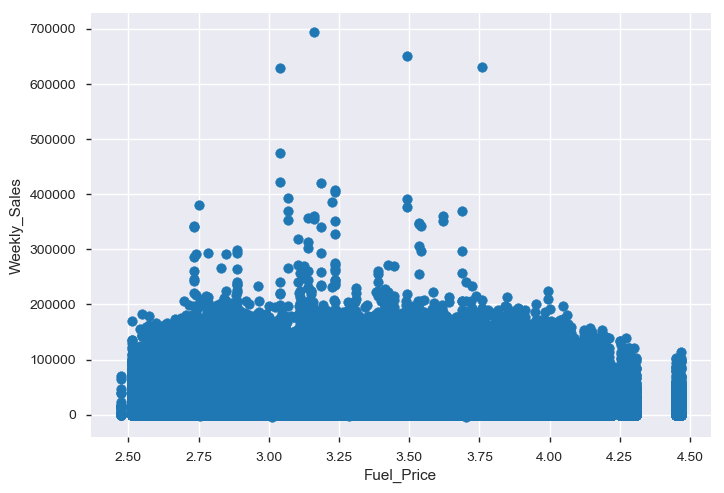

In [23]:
scatter(train,'Fuel_Price')

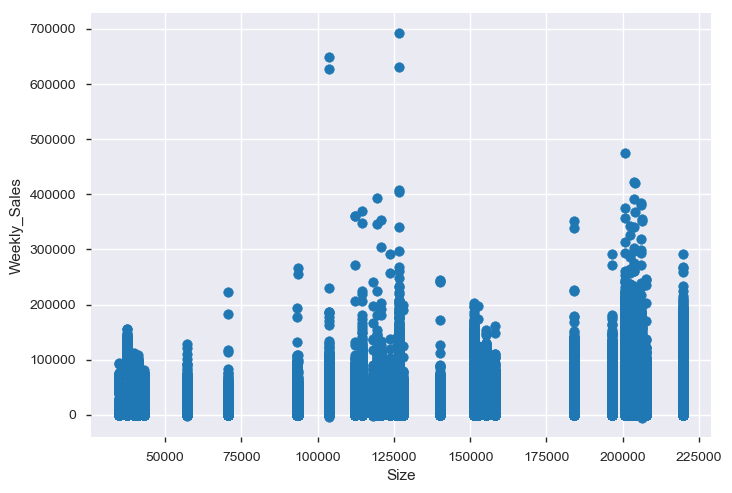

In [24]:
scatter(train,'Size')

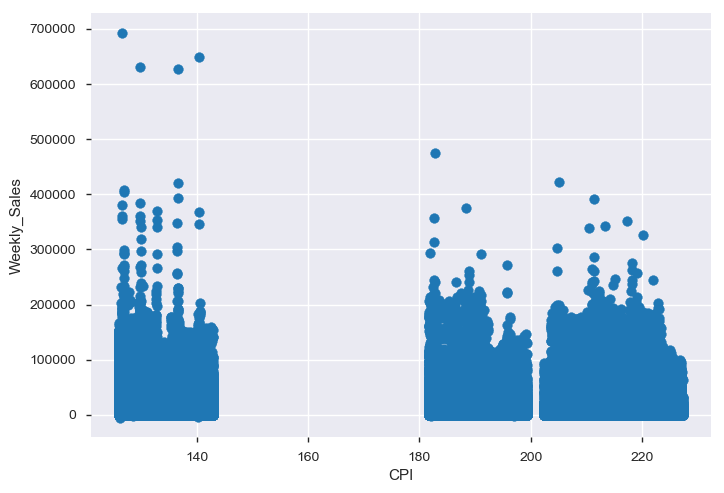

In [25]:
scatter(train,'CPI')

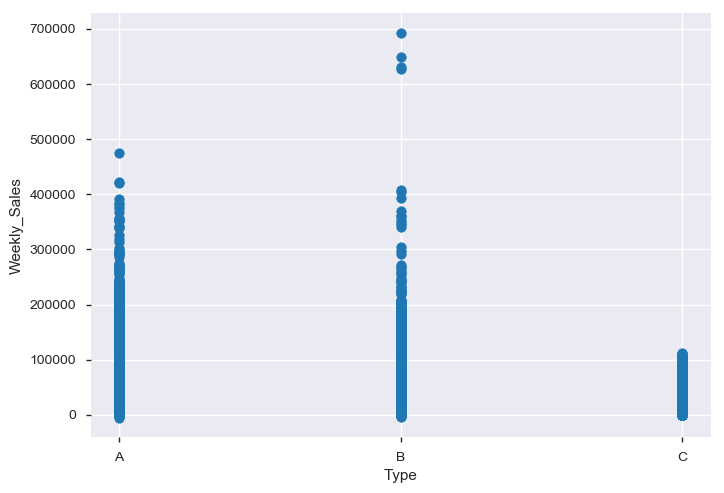

In [26]:
scatter(train,'Type')

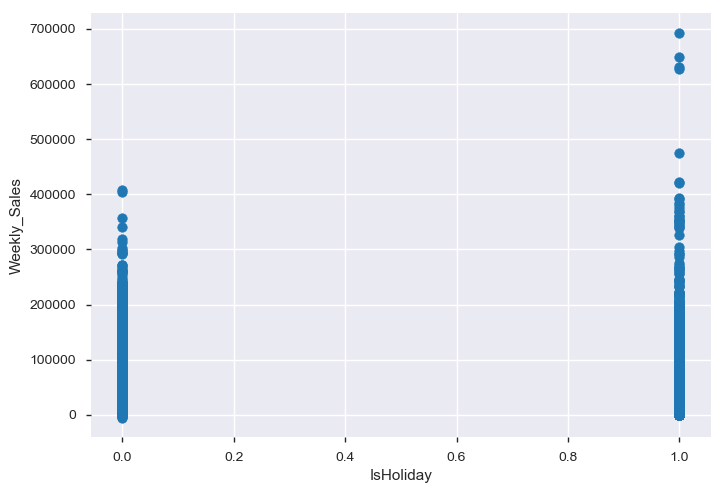

In [27]:
scatter(train,'IsHoliday')

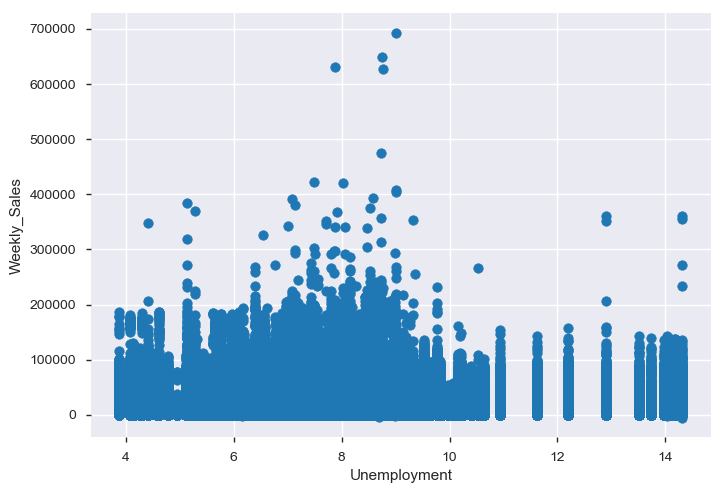

In [28]:
scatter(train,'Unemployment')

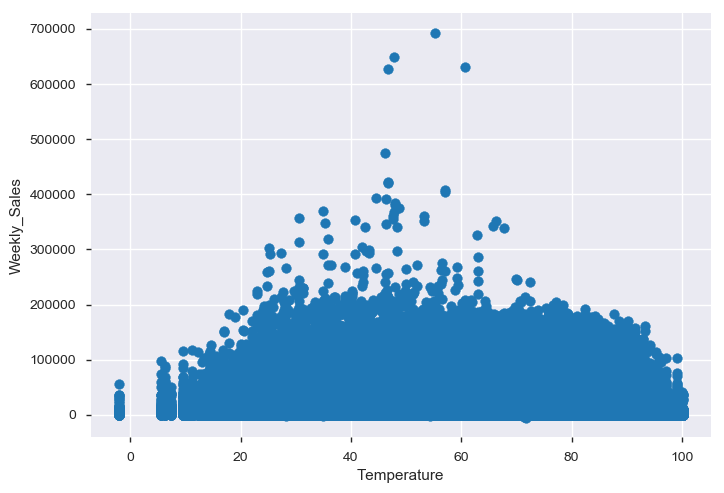

In [29]:
scatter(train,'Temperature')

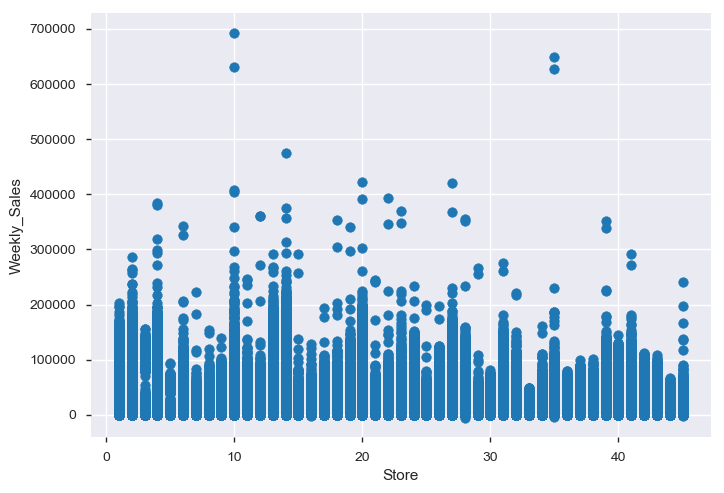

In [30]:
scatter(train,'Store')

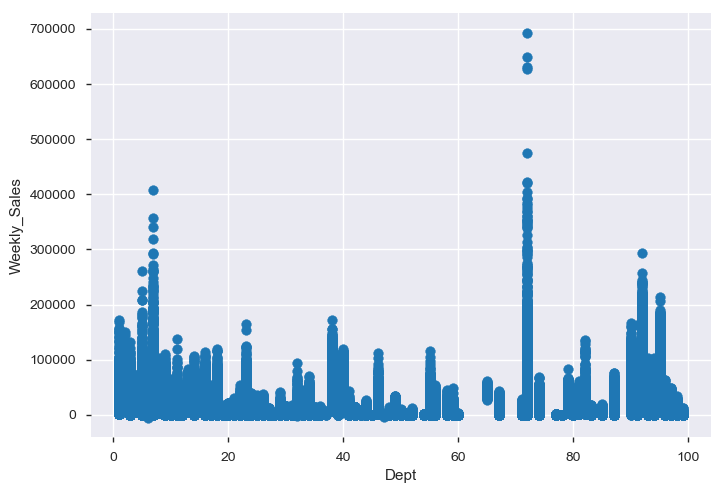

In [31]:
scatter(train,'Dept')

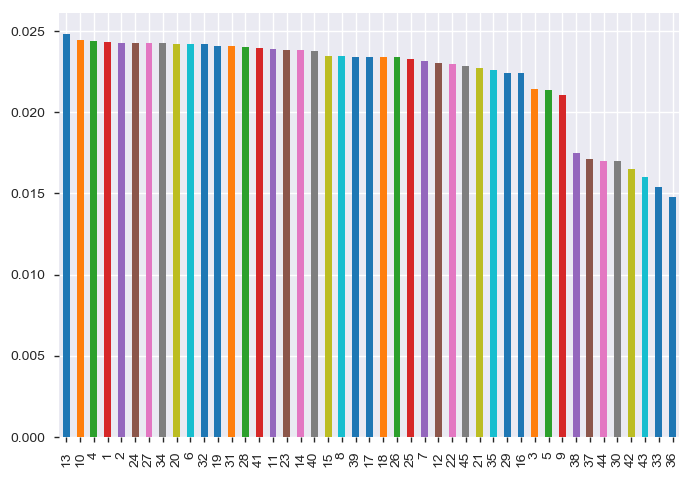

In [38]:
train['Store'].value_counts(normalize=True).plot(kind='bar',fig=(2,3))

More number of store 13 and less number of store 36

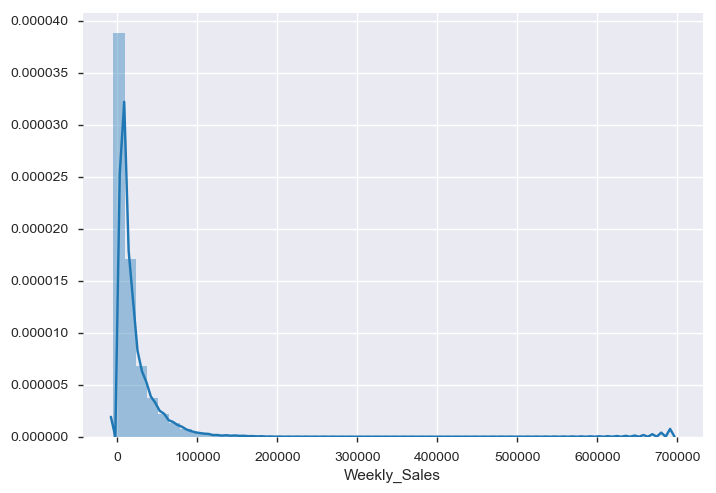

In [39]:
#distribution plot on weekly_sales
sns.distplot(train.Weekly_Sales)

#### Store size Vs Sales

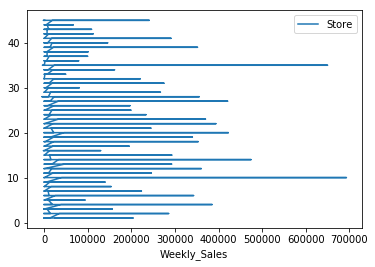

In [19]:
train.plot(kind='line',x='Weekly_Sales',y='Store')

Store 10 has highest sales

#### Sales Vs Type

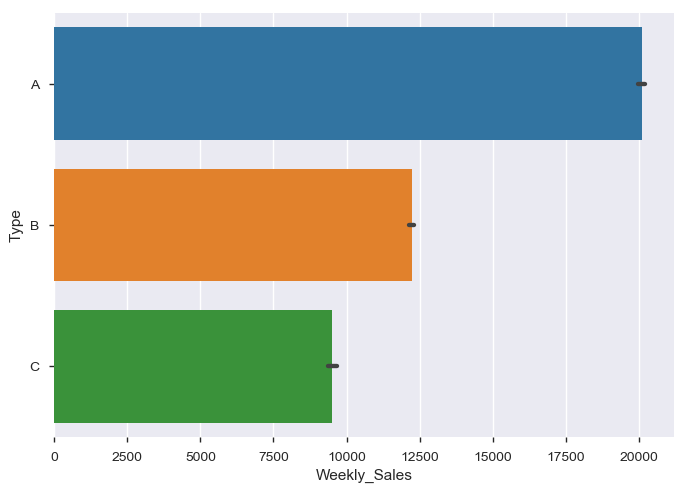

In [42]:
sns.barplot(x=train['Weekly_Sales'],y=train['Type'])

Type A store has more sales and type C store has very less sales

#### Sales Vs Department

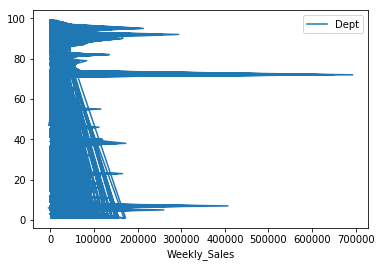

In [72]:
train.plot(kind='line',x='Weekly_Sales',y='Dept')

Department with highest sales lies between Dept 60 to 80

### Creating new features from given data 

#### Date Features

In [18]:
#Creating new features from existing feature
train.Date=pd.to_datetime(train.Date)
test.Date=pd.to_datetime(test.Date)
train['weekDay']=train.Date.dt.dayofweek
train["Year"]=train.Date.dt.year
train["Week"]=train.Date.dt.week
train["Day"]=train.Date.dt.day
test['weekDay']=test.Date.dt.dayofweek
test["Year"]=test.Date.dt.year
test["Week"]=test.Date.dt.week
test["Day"]=test.Date.dt.day

In [19]:
train.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,weekDay,Year,Week,Day
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,2010,5,5
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,2010,5,5
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,2010,5,5


In [20]:
test.head(3)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,weekDay,Year,Week,Day
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,4,2012,44,2
1,1,2,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,4,2012,44,2
2,1,3,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,4,2012,44,2


In [21]:
#train["BeforeChristmas"] = train.Week == 51
#test["BeforeChristmas"] = test.Week == 51
#train["ThanksGivingDay"]=train.Week == 47
#test["ThanksGivingDay"]=test.Week == 47

In [22]:
#Creating new features from existing feature
train['superBowl'] = np.where((train['Date']==datetime(2010,2,12))|(train['Date']==datetime(2011,2,11))|
                              (train['Date']==datetime(2012,2,10))|(train['Date']==datetime(2013,2,8)),1,0)
train['labourDay'] = np.where((train['Date']==datetime(2010,9,10))|(train['Date']==datetime(2011,9,9))|
                              (train['Date']==datetime(2012,9,7))|(train['Date']==datetime(2013,9,6)),1,0)
train['ThanksGivingDay'] = np.where((train['Date']==datetime(2010,11,26))|(train['Date']==datetime(2011,11,25))|
                              (train['Date']==datetime(2012,11,23))|(train['Date']==datetime(2013,11,29)),1,0)
train['BeforeChristmas'] = np.where((train['Date']==datetime(2010,12,31))|(train['Date']==datetime(2011,12,30))|
                              (train['Date']==datetime(2012,12,28))|(train['Date']==datetime(2013,12,27)),1,0)

In [23]:
test['superBowl'] = np.where((test['Date']==datetime(2010,2,12))|(test['Date']==datetime(2011,2,11))|
                              (test['Date']==datetime(2012,2,10))|(test['Date']==datetime(2013,2,8)),1,0)
test['labourDay'] = np.where((test['Date']==datetime(2010,9,10))|(test['Date']==datetime(2011,9,9))|
                              (test['Date']==datetime(2012,9,7))|(test['Date']==datetime(2013,9,6)),1,0)
test['ThanksGivingDay'] = np.where((test['Date']==datetime(2010,11,26))|(test['Date']==datetime(2011,11,25))|
                              (test['Date']==datetime(2012,11,23))|(test['Date']==datetime(2013,11,29)),1,0)
test['BeforeChristmas'] = np.where((test['Date']==datetime(2010,12,31))|(test['Date']==datetime(2011,12,30))|
                              (test['Date']==datetime(2012,12,28))|(test['Date']==datetime(2013,12,27)),1,0)

In [24]:
print(train.BeforeChristmas.value_counts())
print(train.ThanksGivingDay.value_counts())
print("="*30)
print(train.BeforeChristmas.value_counts())
print(train.ThanksGivingDay.value_counts())

0    415624
1      5946
Name: BeforeChristmas, dtype: int64
0    415611
1      5959
Name: ThanksGivingDay, dtype: int64
0    415624
1      5946
Name: BeforeChristmas, dtype: int64
0    415611
1      5959
Name: ThanksGivingDay, dtype: int64


In [25]:
print(train.IsHoliday.value_counts())

False    391909
True      29661
Name: IsHoliday, dtype: int64


#### IsHoliday value depending on these new holidays

In [26]:
train['IsHoliday']=train['IsHoliday']|train['superBowl']|train['labourDay']|train['ThanksGivingDay']|train['BeforeChristmas']
test['IsHoliday']=test['IsHoliday']|test['superBowl']|test['labourDay']|test['ThanksGivingDay']|test['BeforeChristmas']

In [27]:
print(train.IsHoliday.value_counts())

False    391909
True      29661
Name: IsHoliday, dtype: int64


In [28]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,CPI,Unemployment,weekDay,Year,Week,Day,superBowl,labourDay,ThanksGivingDay,BeforeChristmas
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,...,211.096358,8.106,4,2010,5,5,0,0,0,0
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,0.0,...,211.096358,8.106,4,2010,5,5,0,0,0,0
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,0.0,...,211.096358,8.106,4,2010,5,5,0,0,0,0
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,0.0,...,211.096358,8.106,4,2010,5,5,0,0,0,0
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,0.0,...,211.096358,8.106,4,2010,5,5,0,0,0,0


In [29]:
print(train.Type.value_counts())
print("="*30)
print(test.Type.value_counts())

A    215478
B    163495
C     42597
Name: Type, dtype: int64
A    58713
B    44500
C    11851
Name: Type, dtype: int64


In [30]:
print(train.IsHoliday.value_counts())
print("="*30)
print(test.IsHoliday.value_counts())

False    391909
True      29661
Name: IsHoliday, dtype: int64
False    106136
True       8928
Name: IsHoliday, dtype: int64


In [31]:
train_test = [train,test]

In [32]:
#converting Type column categorical variable into numeric variable
mapping = {"A":1,"B":2,"C":3}
for data in train_test:
    data['Type'] = data['Type'].map(mapping)

In [33]:
#converting Isholiday column categorical variable into numeric variable
mapping = {True:1,False:0}
for data in train_test:
    data['IsHoliday'] = data['IsHoliday'].map(mapping)

In [34]:
train.shape

(421570, 24)

In [35]:
train.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,CPI,Unemployment,weekDay,Year,Week,Day,superBowl,labourDay,ThanksGivingDay,BeforeChristmas
0,1,1,2010-02-05,24924.50,0,1,151315,42.31,2.572,0.0,...,211.096358,8.106,4,2010,5,5,0,0,0,0
1,1,2,2010-02-05,50605.27,0,1,151315,42.31,2.572,0.0,...,211.096358,8.106,4,2010,5,5,0,0,0,0
2,1,3,2010-02-05,13740.12,0,1,151315,42.31,2.572,0.0,...,211.096358,8.106,4,2010,5,5,0,0,0,0


These features are motivated that before holiday comes, more and more people are going for shopping, and thus the weekly sales before/during holiday weeks increase,after that weekly sales begin to fall.

In [36]:
train.drop(['superBowl','labourDay','ThanksGivingDay','BeforeChristmas','Unemployment','CPI','MarkDown5'],axis=1,inplace=True)
test.drop(['superBowl','labourDay','ThanksGivingDay','BeforeChristmas','Unemployment','CPI','MarkDown5'],axis=1,inplace=True)

In [37]:
train.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,weekDay,Year,Week,Day
0,1,1,2010-02-05,24924.50,0,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,4,2010,5,5
1,1,2,2010-02-05,50605.27,0,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,4,2010,5,5
2,1,3,2010-02-05,13740.12,0,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,4,2010,5,5


In [38]:
test.head(3)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,weekDay,Year,Week,Day
0,1,1,2012-11-02,0,1,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,4,2012,44,2
1,1,2,2012-11-02,0,1,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,4,2012,44,2
2,1,3,2012-11-02,0,1,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,4,2012,44,2


### Splitting train data into train and test as 80%-20%

In [39]:
#Label with Weekly_Sales
train_y = train['Weekly_Sales']
#drop Weekly_sales column in train data
train_X = train.drop(['Weekly_Sales','Date'],axis=1)
test_X = test.drop(['Date'],axis=1)

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

In [41]:
print("train data shape",X_train.shape)
print("test data shape",X_test.shape)

train data shape (337256, 15)
test data shape (84314, 15)


In [42]:
print("test_X shape",test_X.shape)

test_X shape (115064, 15)


In [43]:
#data preprocessing : Standardizing the data
from sklearn.preprocessing import StandardScaler
standardized_data=StandardScaler()
X_train=standardized_data.fit_transform(X_train)
X_test=standardized_data.transform(X_test)

In [44]:
def plot_prediction(predicted,true,description):
    fig, ax = plt.subplots()
    ax.scatter(true, predicted, edgecolors=(0, 0, 0))
    ax.plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted by '+description)
    ax.plot([-30,30], [0,0], 'k-')   
    ax.plot([0,0], [-30,30], 'k-')
    plt.show()

### RandomForestRegressor with default parameters

In [59]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
#accuracy on train data
accuracy = round(rf.score(X_train, y_train)*100, 2)
print("Accuracy:",accuracy)

Accuracy: 99.67


In [61]:
r2_score_rf = r2_score(y_test, y_pred)
print("r2 score:",r2_score_rf)

r2 score: 0.9770462117928799


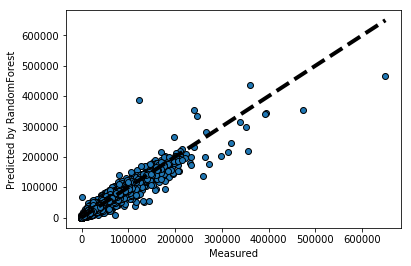

In [48]:
plot_prediction(y_pred,y_test,"RandomForest")

In [48]:
#accuracy on test data
#accuracy = round(rf.score(X_test, y_test)*100, 2)
#print("Accuracy:",accuracy)

Accuracy: 97.74


In [49]:
# calculate the accuray of the model by mean squared error and mean absolute error
print(metrics.mean_absolute_error(y_test,y_pred))
print(metrics.mean_squared_error(y_test,y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

1343.4802796783454
11753251.327107681
3428.301522198373


### DecisionTreeRegressor

In [62]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
#accuracy on test data
accuracy = round(dt.score(X_test, y_test)*100, 2)
print("Accuracy:",accuracy)

Accuracy: 95.19


In [63]:
r2_score_dt = r2_score(y_test, y_pred)
print("r2 score:",r2_score_dt)

r2 score: 0.9519044132074155


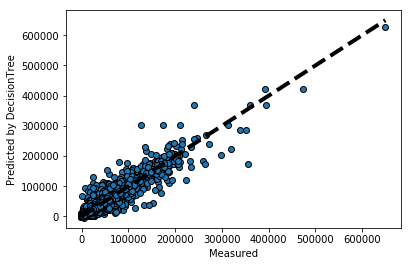

In [51]:
plot_prediction(y_pred,y_test,"DecisionTree")

In [52]:
# calculate the accuray of the model by mean squared error and mean absolute error
print(metrics.mean_absolute_error(y_test,y_pred))
print(metrics.mean_squared_error(y_test,y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

1786.5755529330836
19202185.512105696
4382.02983925323


In [57]:
#from statsmodels.tsa.arima_model import ARIMA
#model = ARIMA(X, 1,1,0)
#model_fit = model.fit(disp=0)
#y_pred_arima = model_fit.forecast()

#print("prediction:",y_pred_arima)

### KNN Regressor

In [64]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
#accuracy on test data
accuracy = round(knn.score(X_test, y_test)*100, 2)
#print("Accuracy:",accuracy)

In [65]:
r2_score_knn = r2_score(y_test, y_pred_knn)
print("r2 score:",r2_score_knn)

r2 score: 0.2426964829268412


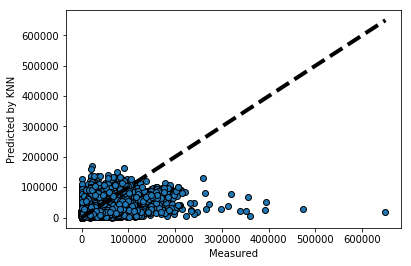

In [55]:
plot_prediction(y_pred_knn,y_test,"KNN")

In [56]:
# calculate the accuray of the model by mean squared error and mean absolute error
print(metrics.mean_absolute_error(y_test,y_pred_knn))
print(metrics.mean_squared_error(y_test,y_pred_knn))
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred_knn)))

12402.646285385585
398133463.6704608
19953.282027537745


### ExtraTreeRegressor

#### Hyperparameter tuning to find best parameters

In [129]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor
n_estimators=[50,100,150,200,250,300]
max_depth = [4,6,8,10,12]
min_samples_split = [2,5]
min_samples_leaf= [1,2]
bootstrap = [True,False]
param_grid= { 'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}
etr= ExtraTreesRegressor(n_estimators=100, verbose=0, n_jobs=30)
etr_random = RandomizedSearchCV(estimator = etr, param_distributions = param_grid, n_iter = 8, cv= 5 , verbose= 2, 
                                random_state=42, n_jobs=1)
etr_random.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] min_samples_split=2, min_samples_leaf=1, bootstrap=True .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_samples_split=2, min_samples_leaf=1, bootstrap=True, total= 6.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.4min remaining:    0.0s


[CV] min_samples_split=2, min_samples_leaf=1, bootstrap=True .........
[CV]  min_samples_split=2, min_samples_leaf=1, bootstrap=True, total= 2.1min
[CV] min_samples_split=2, min_samples_leaf=1, bootstrap=True .........
[CV]  min_samples_split=2, min_samples_leaf=1, bootstrap=True, total= 2.7min
[CV] min_samples_split=2, min_samples_leaf=1, bootstrap=True .........
[CV]  min_samples_split=2, min_samples_leaf=1, bootstrap=True, total= 2.7min
[CV] min_samples_split=2, min_samples_leaf=1, bootstrap=True .........
[CV]  min_samples_split=2, min_samples_leaf=1, bootstrap=True, total= 2.6min
[CV] min_samples_split=5, min_samples_leaf=1, bootstrap=True .........
[CV]  min_samples_split=5, min_samples_leaf=1, bootstrap=True, total= 2.1min
[CV] min_samples_split=5, min_samples_leaf=1, bootstrap=True .........
[CV]  min_samples_split=5, min_samples_leaf=1, bootstrap=True, total= 2.0min
[CV] min_samples_split=5, min_samples_leaf=1, bootstrap=True .........
[CV]  min_samples_split=5, min_samples_le

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 126.9min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=30,
          oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=8, n_jobs=1,
          param_distributions={'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [130]:
etr_random.best_estimator_

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=2, min_samples_split=5,
          min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=30,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [66]:
etr_random_best = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=2, min_samples_split=5,
          min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=30,
          oob_score=False, random_state=None, verbose=0, warm_start=False)
etr_random_best.fit(X_train,y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=2, min_samples_split=5,
          min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=30,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [67]:
y_pred = etr_random_best.predict(X_test)
etr_random_best.score(X_test,y_test)

0.9729289945120269

In [68]:
r2_score_etr = r2_score(y_test, y_pred)
print("r2 score:",r2_score_etr)

r2 score: 0.9729289945120269


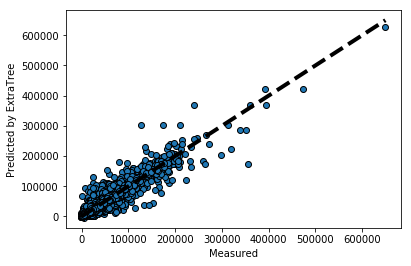

In [59]:
plot_prediction(y_pred,y_test,"ExtraTree")

In [63]:
# calculate the accuray of the model by mean squared error and mean absolute error

print(metrics.mean_absolute_error(y_test,y_pred))
print(metrics.mean_squared_error(y_test,y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

1786.5755529330836
19202185.512105696
4382.02983925323


In [47]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.metrics import r2_score


In [48]:
alpha = 0.1
lasso = Lasso(alpha=alpha)

y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.086934


In [49]:
enet = ElasticNet(alpha=alpha, l1_ratio=0.7)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.7,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.086614


In [51]:
enet.coef_

array([-1090.65012521,  3295.88392349,    74.9263663 ,   750.5457985 ,
        5693.26003198,   125.04303196,   355.89035596,   255.82343344,
          61.59671578,   603.86434565,    74.14953268,     0.        ,
        -570.11924226,   439.4806757 ,  -171.93963985])

In [52]:
lasso.coef_

array([-1134.3619805 ,  3395.67002489,    78.215786  ,  1231.51795475,
        6251.63635739,   133.8491011 ,   369.55561069,   241.02677739,
          51.77694443,   612.65459193,    61.71728352,     0.        ,
        -583.84135256,   446.03621456,  -182.14801323])

NameError: name 'coef' is not defined

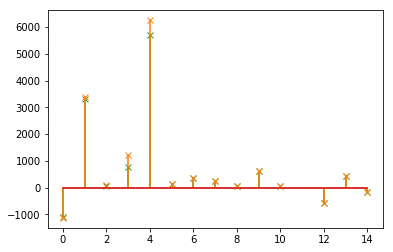

In [50]:
m, s, _ = plt.stem(np.where(enet.coef_)[0], enet.coef_[enet.coef_ != 0],
                   markerfmt='x', label='Elastic net coefficients')
plt.setp([m, s], color="#2ca02c")
m, s, _ = plt.stem(np.where(lasso.coef_)[0], lasso.coef_[lasso.coef_ != 0],
                   markerfmt='x', label='Lasso coefficients')
plt.setp([m, s], color='#ff7f0e')
plt.stem(np.where(coef)[0], coef[coef != 0], label='true coefficients',
         markerfmt='bx')

plt.legend(loc='best')
plt.title("Lasso $R^2$: %.3f, Elastic Net $R^2$: %.3f"
          % (r2_score_lasso, r2_score_enet))
plt.show()

In [53]:
y_pred_lasso = lasso.predict(test_X)

In [54]:
y_pred_enet = enet.predict(test_X)

In [57]:
#Predicting values using averaging Models
submission = pd.DataFrame({
    "ID":test.Store.astype(str)+'_'+test.Dept.astype(str)+'_'+test.Date.astype(str),"Weekly_Sales":y_pred_lasso})
submission.to_csv('weekly_sales_predicted_lasso.csv',index=False)

In [58]:
submission = pd.DataFrame({
    "ID":test.Store.astype(str)+'_'+test.Dept.astype(str)+'_'+test.Date.astype(str),"Weekly_Sales":y_pred_enet})
submission.to_csv('weekly_sales_predicted_enet.csv',index=False)

#### Predicting sales value for test data based on RandomForestModel

In [110]:
y_pred_rf = rf.predict(test_X)

In [111]:
#Predicting values using RandomForest Model
submission = pd.DataFrame({
    "ID":test.Store.astype(str)+'_'+test.Dept.astype(str)+'_'+test.Date.astype(str),"Weekly_Sales":y_pred_rf})
submission.to_csv('weekly_sales_predicted.csv',index=False)

In [116]:
predicted_sales = pd.read_csv('weekly_sales_predicted.csv')

In [117]:
predicted_sales.head()

,ID,Weekly_Sales
0,1_1_2012-11-02,37777.8829
1,1_2_2012-11-02,47662.1197
2,1_3_2012-11-02,10807.9500
3,1_4_2012-11-02,39831.1594
4,1_5_2012-11-02,30310.3086


Predicted weekly_sales for test data

In [71]:
from prettytable import PrettyTable
pretty_table = PrettyTable()
pretty_table.field_names = ["Model", "MAE", "MSE","RMSE","R² score"]
pretty_table.add_row(["KNNRegressor",11764,363811493,19073.84,0.2426])
pretty_table.add_row(["\n","\n","\n","\n","\n"])

pretty_table.add_row(["RandomForestRegressor",1343,11807496,3436,0.9770])
pretty_table.add_row(["\n","\n","\n","\n","\n"])

pretty_table.add_row(["DecisionTreeRegressor",1796,24869226,4986,0.9519])
pretty_table.add_row(["\n","\n","\n","\n","\n"])

pretty_table.add_row(["ExtraTreeRegressor",1356,14130565,3759,0.9729])
print(pretty_table)

+-----------------------+-------+-----------+----------+----------+
|         Model         |  MAE  |    MSE    |   RMSE   | R² score |
+-----------------------+-------+-----------+----------+----------+
|      KNNRegressor     | 11764 | 363811493 | 19073.84 |  0.2426  |
|                       |       |           |          |          |
|                       |       |           |          |          |
| RandomForestRegressor |  1343 |  11807496 |   3436   |  0.977   |
|                       |       |           |          |          |
|                       |       |           |          |          |
| DecisionTreeRegressor |  1796 |  24869226 |   4986   |  0.9519  |
|                       |       |           |          |          |
|                       |       |           |          |          |
|   ExtraTreeRegressor  |  1356 |  14130565 |   3759   |  0.9729  |
+-----------------------+-------+-----------+----------+----------+


## Conclusion:
1.Performed some Exploratory Data Analysis on given data after combining all the .csv files.
    
2.Feature engineering by adding features based on the existing features data.
    
3.RandomForestRegressor,KNNRegressor,DecisionTreeRegressor and ExtraTreesRegressor models used to predict the mse,mae and rmse on train data and test data.A randomforest shown low mean squared error so predicted final test data values.
      
5.Predicted weekly_sales for test data which is stored in csv file and submitted in kaggle competition with score as 2943. 